# FitNets - Feature Based Knowledge Distillation

#### Importing Libraries

In [1]:
import keras
import random
import numpy as np
import tensorflow as tf
from keras import Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input

#### Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


#### Visualize Data

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)
X_test  shape: (10000, 32, 32, 3)
Y_test  shape: (10000, 1)


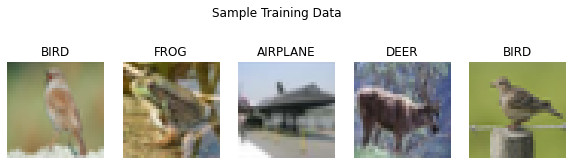

In [3]:
print("X_train shape:", x_train.shape)
print("Y_train shape:", y_train.shape)
print("X_test  shape:", x_test.shape)
print("Y_test  shape:", y_test.shape)

labels = ["AIRPLANE", "AUTOMOBILE", "BIRD", "CAT", "DEER", "DOG", "FROG", "HORSE", "SHIP", "TRUCK"]
plt.figure(figsize = (10, 3))
plt.suptitle("Sample Training Data")
for i in range(1, 6):
    plt.subplot(1, 5, i)
    ran_int = random.randint(0, x_train.shape[0])
    plt.imshow(x_train[ran_int], cmap="gray")
    plt.title(labels[y_train[ran_int][0]])
    plt.axis('off')
plt.show()


#### Scale Data & Get One hot encoding

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Model Checkpointing

In [5]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "./model_checkpoints/weights",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)

#### Plot Graphs

In [6]:
def plot_graphs(history, model_name, acc = "accuracy", val_acc = "val_accuracy", losss = "loss", val_loss = "val_loss"):
    plt.figure(figsize=(14,3))

    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.title('Classification Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(history.history[acc], color='blue', label='Train')
    plt.plot(history.history[val_acc], color='red', label='Test')
    # lll = len(history.history['accuracy'])
    # plt.xticks(np.arange(lll), range(1, lll + 1))
    plt.legend(loc="lower right")
    
    # plot loss
    plt.subplot(1, 2, 2)
    plt.title('Cross Entropy Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history.history[losss], color='blue', label='Train')
    plt.plot(history.history[val_loss], color='red', label='Test')
    plt.legend(loc="upper right")
    
    plt.suptitle(model_name)
    plt.show()

#### Teacher Model

In [7]:
t_inputs = keras.Input(shape=(32, 32, 3))

t_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_inputs)
t_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_1)
t_3 = MaxPooling2D((2, 2))(t_2)
t_4 = Dropout(0.2)(t_3)
	
t_5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_4)
t_6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_5)
t_7 = MaxPooling2D((2, 2))(t_6)
t_8 = Dropout(0.2)(t_7)

t_9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_8)
t_10 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(t_9)
t_11 = MaxPooling2D((2, 2))(t_10)
t_12 = Dropout(0.2)(t_11)

t_13 = Flatten()(t_12)
t_14 = Dense(128, activation='relu', kernel_initializer='he_uniform')(t_13)
t_15 = Dropout(0.2)(t_14)

t_outputs = Dense(10, activation='softmax')(t_15)

# build model
teacher = keras.models.Model(inputs=t_inputs, outputs=t_outputs)

# compile teacher model
opt = SGD(learning_rate=0.001, momentum=0.9)
teacher.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print("TEACHER SUMMARY")
print(teacher.summary())

TEACHER SUMMARY
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                             

#### Train Teacher

In [8]:
teacher_history = teacher.fit(x_train,
                              y_train, 
                              epochs=200, 
                              batch_size=128, 
                              validation_data=(x_test, y_test),
                              callbacks=[model_checkpoint_callback])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 2.1302 - accuracy: 0.2033
Epoch 1: val_accuracy improved from -inf to 0.30820, saving model to ./model_checkpoints/weights
391/391 [==============================] - 15s 13ms/step - loss: 2.1302 - accuracy: 0.2033 - val_loss: 1.8723 - val_accuracy: 0.3082
Epoch 2/200
387/391 [============================>.] - ETA: 0s - loss: 1.8098 - accuracy: 0.3305
Epoch 2: val_accuracy improved from 0.30820 to 0.38270, saving model to ./model_checkpoints/weights
391/391 [==============================] - 4s 11ms/step - loss: 1.8093 - accuracy: 0.3308 - val_loss: 1.7015 - val_accuracy: 0.3827
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.6653 - accuracy: 0.3873
Epoch 3: val_accuracy improved from 0.38270 to 0.44120, saving model to ./model_checkpoints/weights
391/391 [==============================] - 4s 11ms/step - loss: 1.6653 - accuracy: 0.3873 - val_loss: 1.5401 - val_accuracy: 0.4412
Epoch 4/200
391

#### Predict Teacher

In [9]:
teacher.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5933 - accuracy: 0.8330


[0.5932736396789551, 0.8330000042915344]

#### Teacher Graphs

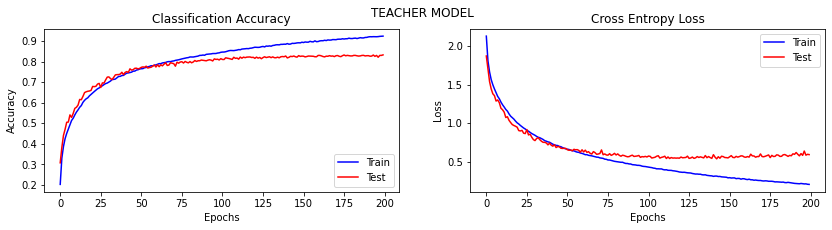

In [10]:
plot_graphs(teacher_history, "TEACHER MODEL")

#### Teacher Hint Layers

In [13]:
teacher_hint = keras.models.Model(inputs=t_inputs, outputs=t_6)
teacher_hint.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print("TEACHER HINT SUMMARY")
print(teacher_hint.summary())

TEACHER HINT SUMMARY
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                      

# STUDENT

#### Student Model

In [30]:
s_inputs = keras.Input(shape=(32, 32, 3))

s_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform')(s_inputs)
s_2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s_1)

s_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform')(s_2)
s_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s_3)

s_5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform')(s_4)
s_6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s_5)

S_regressor = Conv2D(64, (11,11), activation='relu', kernel_initializer='he_uniform')(s_6)

s_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')(s_6)
s_8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s_7)
s_9 = MaxPooling2D((2, 2))(s_8)

s_10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')(s_9)
s_11 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s_10)
s_12 = MaxPooling2D((2, 2))(s_11)

s_13 = Flatten()(s_12)
s_14 = Dense(64, activation='relu', kernel_initializer='he_uniform')(s_13)

s_outputs = Dense(10, activation='softmax')(s_14)

# build model
student = keras.models.Model(inputs=s_inputs, outputs=s_outputs)

# Guided Layers
student_guided = keras.models.Model(inputs=s_inputs, outputs=S_regressor)


# compile student model
student.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# STUDENT BASELINE MODEL

#### Baseline Model

In [31]:
student_baseline = keras.models.clone_model(student)
print("BASELINE STUDENT MODEL")
print(student_baseline.summary())

BASELINE STUDENT MODEL
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_29 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 

#### Baseline Training

In [32]:
student_baseline.compile(
    optimizer = opt,
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy(),
)

# Train and evaluate student trained from scratch.
baseline_history = student_baseline.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
782/782 [==============================] - 10s 12ms/step - loss: 1.9299 - categorical_accuracy: 0.2912 - val_loss: 1.6657 - val_categorical_accuracy: 0.4003
Epoch 2/15
782/782 [==============================] - 9s 11ms/step - loss: 1.5792 - categorical_accuracy: 0.4258 - val_loss: 1.5649 - val_categorical_accuracy: 0.4361
Epoch 3/15
782/782 [==============================] - 8s 11ms/step - loss: 1.4377 - categorical_accuracy: 0.4793 - val_loss: 1.3762 - val_categorical_accuracy: 0.4996
Epoch 4/15
782/782 [==============================] - 8s 11ms/step - loss: 1.3344 - categorical_accuracy: 0.5213 - val_loss: 1.3169 - val_categorical_accuracy: 0.5183
Epoch 5/15
782/782 [==============================] - 8s 11ms/step - loss: 1.2569 - categorical_accuracy: 0.5506 - val_loss: 1.2954 - val_categorical_accuracy: 0.5340
Epoch 6/15
782/782 [==============================] - 9s 11ms/step - loss: 1.1869 - categorical_accuracy: 0.5793 - val_loss: 1.2032 - val_categorical_accuracy: 0.57

#### Baseline Predict

In [33]:
student_baseline.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.0080 - categorical_accuracy: 0.6496


[1.0079782009124756, 0.6496000289916992]

#### Plot Baseline Student Graphs

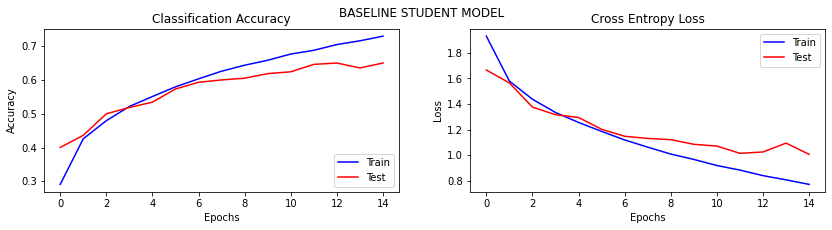

In [34]:
plot_graphs(baseline_history, "BASELINE STUDENT MODEL", "categorical_accuracy", "val_categorical_accuracy")

## Distiller Class

In [35]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
        is_KD_train = False,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        self.is_KD_train = is_KD_train

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            if(self.is_KD_train):
                student_loss = self.student_loss_fn(y, student_predictions)
            else:
                student_loss = 0.0

            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )

            loss = self.alpha * distillation_loss + (1 - self.alpha) * student_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        if(self.is_KD_train):
            self.compiled_metrics.update_state(y, student_predictions)
        else:
            self.compiled_metrics.update_state(teacher_predictions, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"total_loss": loss, "student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# Response Based Learning

#### Response Based Student Model

In [36]:
response_student = keras.models.clone_model(student)
print("STUDENT MODEL (RESPONSE BASED LEARNING)")
print(student_baseline.summary())

STUDENT MODEL (RESPONSE BASED LEARNING)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_29 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)

#### KD Training

In [37]:
response_distiller = Distiller(student=response_student, teacher=teacher)
response_distiller.compile(
    optimizer = opt,
    metrics = tf.keras.metrics.CategoricalAccuracy(),
    student_loss_fn = tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn = tf.keras.losses.CategoricalCrossentropy(),
    alpha=0.2,
    temperature=10,
    is_KD_train = True
)

# Distill teacher to student
response_history = response_distiller.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
782/782 [==============================] - 11s 13ms/step - categorical_accuracy: 0.3103 - total_loss: 1.9610 - student_loss: 1.8756 - distillation_loss: 2.3025 - val_categorical_accuracy: 0.3890 - val_student_loss: 1.5925
Epoch 2/15
782/782 [==============================] - 10s 13ms/step - categorical_accuracy: 0.4459 - total_loss: 1.6767 - student_loss: 1.5203 - distillation_loss: 2.3025 - val_categorical_accuracy: 0.4673 - val_student_loss: 1.4856
Epoch 3/15
782/782 [==============================] - 10s 12ms/step - categorical_accuracy: 0.4998 - total_loss: 1.5696 - student_loss: 1.3863 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5039 - val_student_loss: 1.1280
Epoch 4/15
782/782 [==============================] - 10s 12ms/step - categorical_accuracy: 0.5435 - total_loss: 1.4837 - student_loss: 1.2790 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5340 - val_student_loss: 1.0808
Epoch 5/15
782/782 [==============================] - 10s 13ms/step 

#### Predict

In [38]:
response_distiller.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - categorical_accuracy: 0.6758 - student_loss: 0.9540


[0.6758000254631042, 0.8535149097442627]

#### Plot Graph

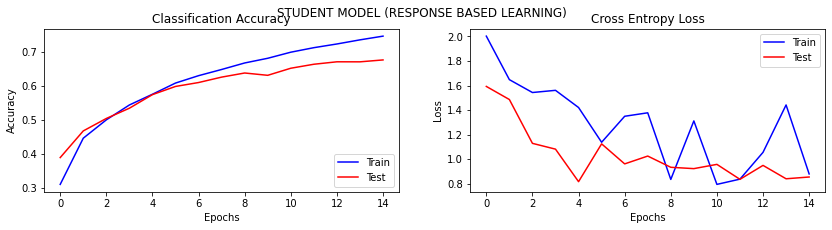

In [39]:
plot_graphs(response_history, "STUDENT MODEL (RESPONSE BASED LEARNING)", "categorical_accuracy", "val_categorical_accuracy", "total_loss", "val_student_loss")

# Feature Based Learning

#### Guided Student Layers

In [40]:
opt = SGD(learning_rate=0.001, momentum=0.9)
student_guided.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print("STUDENT GUIDED LAYERS")
print(student_guided.summary())

STUDENT GUIDED LAYERS
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_29 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 2

#### Hint Training

In [41]:
hint_training = Distiller(student=student_guided, teacher=teacher_hint)
hint_training.compile(
    optimizer = opt,
    metrics = tf.keras.metrics.MeanSquaredError(),
    student_loss_fn = tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn = tf.keras.losses.MeanSquaredError(),
    alpha=1,
    temperature=5,
)

# Distill teacher to student
hint_training.fit(x_train, y_train, epochs=15, batch_size=64)

Epoch 1/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - total_loss: 6.0213e-05 - student_loss: 0.0000e+00 - distillation_loss: 6.0213e-05
Epoch 2/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - total_loss: 6.0227e-05 - student_loss: 0.0000e+00 - distillation_loss: 6.0227e-05
Epoch 3/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - total_loss: 6.0202e-05 - student_loss: 0.0000e+00 - distillation_loss: 6.0202e-05
Epoch 4/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - total_loss: 6.0213e-05 - student_loss: 0.0000e+00 - distillation_loss: 6.0213e-05
Epoch 5/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - total_loss: 6.0223e-05 - student_loss: 0.0000e+00 - distillation_loss: 6.0223e-05
Epoch 6/15
782/782 [==============================] - 8s 10ms/step - mean_squared_error: 0.4263 - to

#### Feature Based Student Model

In [42]:
print("STUDENT MODEL (FEATURE BASED LEARNING)")
print(student.summary())

STUDENT MODEL (FEATURE BASED LEARNING)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_29 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_33 (Conv2D) 

#### KD(Knowledge Distillation) Training

In [44]:
KD_training = Distiller(student=student, teacher=teacher)
KD_training.compile(
    optimizer = opt,
    metrics = tf.keras.metrics.CategoricalAccuracy(),
    student_loss_fn = tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn = tf.keras.losses.CategoricalCrossentropy(),
    alpha=0.2,
    temperature=10,
    is_KD_train = True
)

# Distill teacher to student
distilled_history = KD_training.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
782/782 [==============================] - 11s 13ms/step - categorical_accuracy: 0.4970 - total_loss: 1.5792 - student_loss: 1.3984 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5213 - val_student_loss: 1.0485
Epoch 2/15
782/782 [==============================] - 10s 13ms/step - categorical_accuracy: 0.5392 - total_loss: 1.4901 - student_loss: 1.2870 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5389 - val_student_loss: 1.4132
Epoch 3/15
782/782 [==============================] - 10s 13ms/step - categorical_accuracy: 0.5726 - total_loss: 1.4255 - student_loss: 1.2063 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5725 - val_student_loss: 1.3195
Epoch 4/15
782/782 [==============================] - 10s 12ms/step - categorical_accuracy: 0.5977 - total_loss: 1.3741 - student_loss: 1.1420 - distillation_loss: 2.3024 - val_categorical_accuracy: 0.5585 - val_student_loss: 1.7108
Epoch 5/15
782/782 [==============================] - 10s 13ms/step 

#### Feature Based Distilled Model Predict

In [45]:
KD_training.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - categorical_accuracy: 0.6820 - student_loss: 0.9203


[0.6819999814033508, 1.1376605033874512]

#### Distilled Model Plot Graph

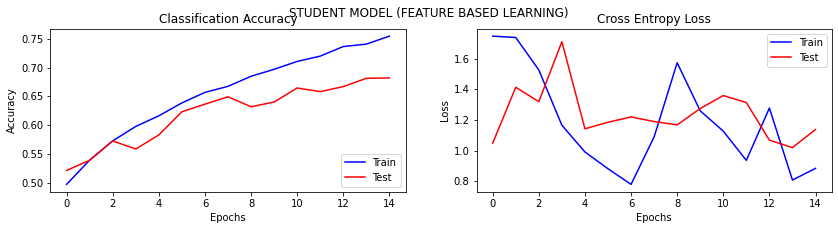

In [46]:
plot_graphs(distilled_history, "STUDENT MODEL (FEATURE BASED LEARNING)", "categorical_accuracy", "val_categorical_accuracy", "total_loss", "val_student_loss")